# Personalizovani PageRank algoritam primenjen na proteinske interakcije

## Pretprocesiranje

U ovoj svesci bice pokazana primena PageRank algoritma na interakciju viralnih proteina enkodiranih od strane SARS-CoV-2. Korisceni podaci se nalaze u okviru direktorijuma `COVID_19_PPI`, a najnoviji azurirani podaci mogu se skinuti [ovde](https://downloads.thebiogrid.org/File/BioGRID/Latest-Release/BIOGRID-PROJECT-covid19_coronavirus_project-LATEST.zip).

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

BioGRID (sajt sa koga su podaci preuzeti) [ovako](https://wiki.thebiogrid.org/doku.php/biogrid_tab_version_3.0) opisuje format `tab3` datoteka.

In [2]:
file_name = 'COVID_19_PPI/BIOGRID-PROJECT-covid19_coronavirus_project-INTERACTIONS-4.4.210.tab3.txt'
df = pd.read_csv(file_name, sep='\t')
df.head()

,#BioGRID Interaction ID,Entrez Gene Interactor A,Entrez Gene Interactor B,BioGRID ID Interactor A,BioGRID ID Interactor B,Systematic Name Interactor A,Systematic Name Interactor B,Official Symbol Interactor A,Official Symbol Interactor B,Synonyms Interactor A,...,TREMBL Accessions Interactor B,REFSEQ Accessions Interactor B,Ontology Term IDs,Ontology Term Names,Ontology Term Categories,Ontology Term Qualifier IDs,Ontology Term Qualifier Names,Ontology Term Types,Organism Name Interactor A,Organism Name Interactor B
0,2652341,43740570,8546,4383845,114116,GU280_gp04,-,E,AP3B1,env|envelope|SARS-CoV2 E|E protein|emp|SARS-Co...,...,-,NP_001258698|NP_003655,-,-,-,-,-,-,Severe acute respiratory syndrome coronavirus 2,Homo sapiens
1,2652342,43740570,23476,4383845,117036,GU280_gp04,-,E,BRD4,env|envelope|SARS-CoV2 E|E protein|emp|SARS-Co...,...,-,NP_001317313|NP_490597|NP_001366221|NP_0013662...,-,-,-,-,-,-,Severe acute respiratory syndrome coronavirus 2,Homo sapiens
2,2652343,43740570,6046,4383845,111973,GU280_gp04,DADB-17J1.3,E,BRD2,env|envelope|SARS-CoV2 E|E protein|emp|SARS-Co...,...,X5CF57|A0A024RCR5,NP_001186384|NP_005095|NP_001278915|NP_0011066...,-,-,-,-,-,-,Severe acute respiratory syndrome coronavirus 2,Homo sapiens
3,2652344,43740570,10283,4383845,115572,GU280_gp04,UNQ438/PRO871,E,CWC27,env|envelope|SARS-CoV2 E|E protein|emp|SARS-Co...,...,D6REK3,NP_001284574|NP_005860|NP_001351407|NP_0013049...,-,-,-,-,-,-,Severe acute respiratory syndrome coronavirus 2,Homo sapiens
4,2652345,43740570,124245,4383845,125858,GU280_gp04,-,E,ZC3H18,env|envelope|SARS-CoV2 E|E protein|emp|SARS-Co...,...,B4DTK7|E7ERS3,NP_653205|NP_001281269,-,-,-,-,-,-,Severe acute respiratory syndrome coronavirus 2,Homo sapiens


In [3]:
df.shape

(29716, 37)

Podaci su preprocesirani na sledeci nacin:
1. preimnovana je prva kolona da ne sadrzi `#` na pocetku
1. vrednosti `-` su zamenjene sa `np.nan` zbog lakseg rukovanja
1. odbaceni su redovi koji sadrze nedostajuce vrednosti
1. odbacene su kolone koje sadrze nedostajuce vrednosti

In [4]:
df.rename(mapper=lambda col: col.lstrip('#'), axis=1, inplace=True)
df = df.applymap(lambda x: np.nan if x == "-" else x)
df.dropna(subset=['Entrez Gene Interactor A', 'Entrez Gene Interactor B'], inplace=True)
df.dropna(axis=1, inplace=True)
df.head()

,BioGRID Interaction ID,Entrez Gene Interactor A,Entrez Gene Interactor B,BioGRID ID Interactor A,BioGRID ID Interactor B,Official Symbol Interactor A,Official Symbol Interactor B,Experimental System,Experimental System Type,Author,Publication Source,Organism ID Interactor A,Organism ID Interactor B,Throughput,Source Database,Organism Name Interactor A,Organism Name Interactor B
0,2652341,43740570,8546,4383845,114116,E,AP3B1,Affinity Capture-MS,physical,Gordon DE (2020),PUBMED:32353859,2697049,9606,High Throughput,BIOGRID,Severe acute respiratory syndrome coronavirus 2,Homo sapiens
1,2652342,43740570,23476,4383845,117036,E,BRD4,Affinity Capture-MS,physical,Gordon DE (2020),PUBMED:32353859,2697049,9606,High Throughput,BIOGRID,Severe acute respiratory syndrome coronavirus 2,Homo sapiens
2,2652343,43740570,6046,4383845,111973,E,BRD2,Affinity Capture-MS,physical,Gordon DE (2020),PUBMED:32353859,2697049,9606,High Throughput,BIOGRID,Severe acute respiratory syndrome coronavirus 2,Homo sapiens
3,2652344,43740570,10283,4383845,115572,E,CWC27,Affinity Capture-MS,physical,Gordon DE (2020),PUBMED:32353859,2697049,9606,High Throughput,BIOGRID,Severe acute respiratory syndrome coronavirus 2,Homo sapiens
4,2652345,43740570,124245,4383845,125858,E,ZC3H18,Affinity Capture-MS,physical,Gordon DE (2020),PUBMED:32353859,2697049,9606,High Throughput,BIOGRID,Severe acute respiratory syndrome coronavirus 2,Homo sapiens


In [5]:
df.shape

(27189, 17)

Odbaceno je 2527 redova i 20 kolona. Odbacene kolone nisu od interesa jer se ne koriste za konstrukciju grafa. Kao identifikatori cvorova, bice korisceni identifikatori gena a simboli ce biti korisceni kao labele. Pokazuje se da simboli gena ne odredjuju jednoznacno konkretan gen. Takodje, kolone `BioGRID ID Interactor {A,B}` su semanticki identicne `Entrez Gene Interactor {A,B}` kolonama. Jedina razlika je sto se koriste za pretrazivanje razlicitih onlajn baza gena.

In [10]:
cols = [
    'Entrez Gene Interactor A',
    'Entrez Gene Interactor B',
    'BioGRID ID Interactor A',
    'BioGRID ID Interactor B',
    'Official Symbol Interactor A',
    'Official Symbol Interactor B'
]

df = pd.DataFrame(data=df[cols].to_numpy(), columns=cols, index=list(df['BioGRID Interaction ID']))


KeyError: 'BioGRID Interaction ID'

In [7]:
def different_ids_for_symbols(db_name):
    db = {}
        
    for _, row in df.iterrows():
        for sym in ['A', 'B']:
            symbol = row[f'Official Symbol Interactor {sym}']
            interactor_id = row[f'{db_name} {sym}']
            
            ids = db.get(symbol, set())
            ids.add(interactor_id)
            db[symbol] = ids

    return db

entrez = different_ids_for_symbols('Entrez Gene Interactor')
biogrid = different_ids_for_symbols('BioGRID ID Interactor')
    
for symbol, ids in entrez.items():
    if symbol not in biogrid:
        print(f'symbol {symbol} does not exist in biogrid')
    elif len(biogrid[symbol]) != len(ids):
        print(f'lens differ {symbol}')

In [8]:
G = nx.DiGraph()

for interaction_id, (entrez_id_a, entrez_id_b, biogrid_id_a, biogrid_id_b, symbol_a, symbol_b) in df.iterrows():
    G.add_node(entrez_id_a, biogrid_id=biogrid_id_a, label=symbol_a)
    G.add_node(entrez_id_b, biogrid_id=biogrid_id_b, label=symbol_b)
    G.add_edge(entrez_id_a, entrez_id_b, interaction_id=interaction_id)
    
scores = nx.pagerank(G, alpha=0.9)
scores_sorted = sorted(scores.items(), key=lambda x: x[1], reverse=True)

node_label = lambda symbol: G.nodes[symbol]['label']

N = 20

topN = pd.DataFrame(
    [[node, node_label(node), score] for (node, score) in scores_sorted[:N]],
    columns=['entrez_id', 'symbol', 'score'])
topN

,entrez_id,symbol,score
0,43740568,S,0.008596
1,43740575,N,0.002395
2,1489678,N,0.002154
3,1489668,S,0.001866
4,1489680,nsp1ab,0.001314
5,14254594,S,0.001304
6,43740578,nsp1,0.001247
7,43740570,E,0.001162
8,1489674,ORF7a,0.001015
9,1489669,ORF3a,0.000748


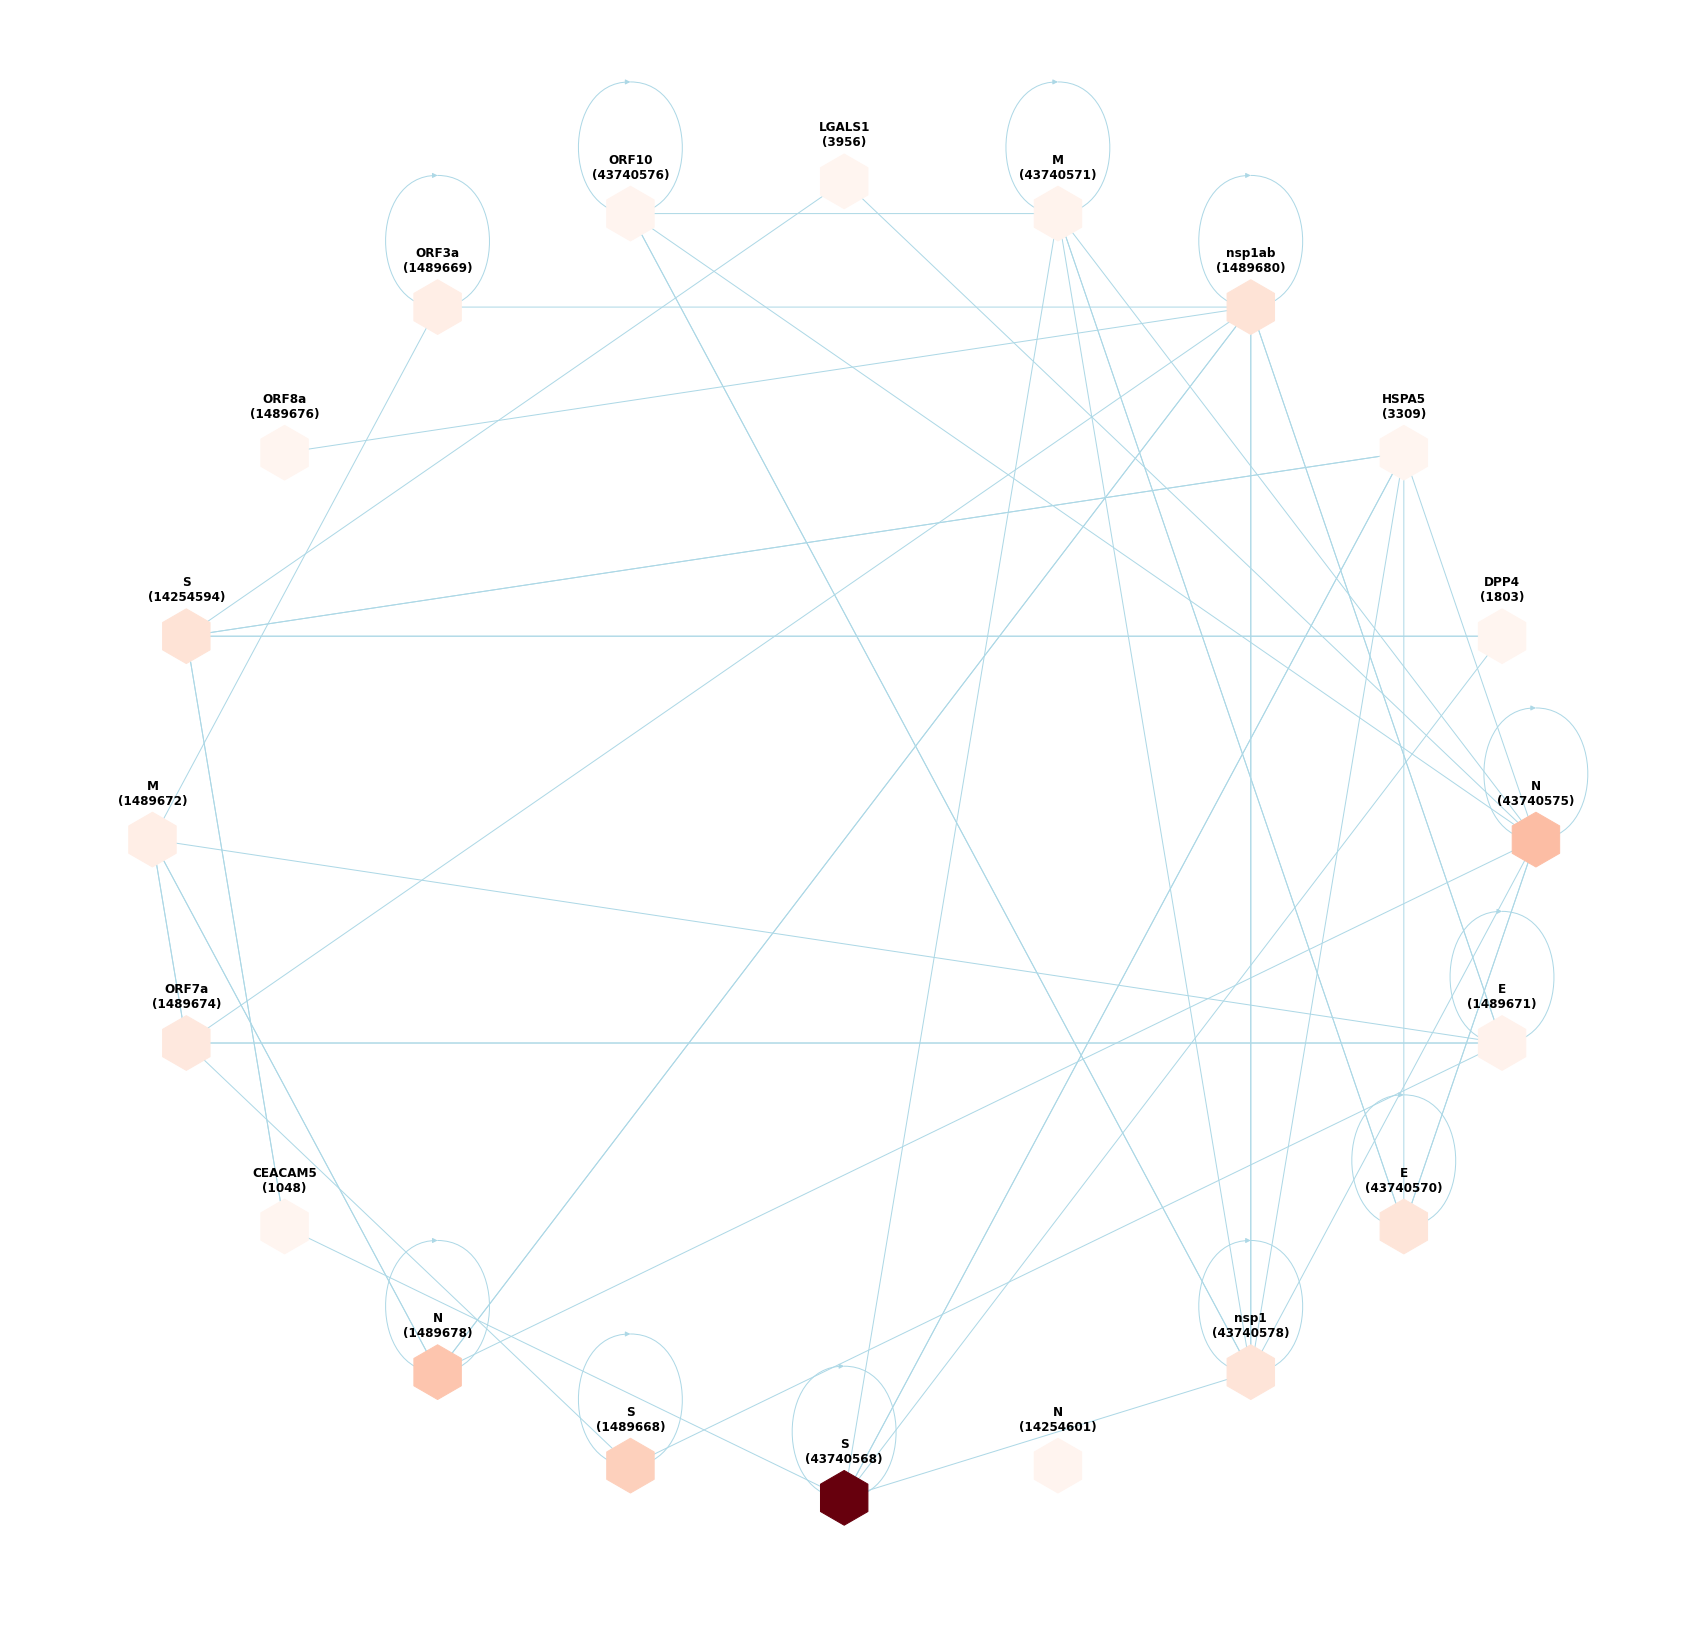

In [9]:
subg = G.subgraph(list(topN['entrez_id']))

pos = nx.circular_layout(subg)
    
plt.figure(figsize=(30, 30))

colors = [scores[node] for node in subg.nodes()]

# Iscrtavamo cvorove
nx.draw_networkx_nodes(subg, pos, cmap=plt.cm.Reds, node_color=colors, node_size=3000, node_shape='h')

# Iscrtavamo oznake cvorova
labels = {node: f'{data["label"]}\n({node})' for (node, data) in subg.nodes.items()}
label_pos = {k: (v[0], v[1]+0.07) for (k, v) in pos.items()}
nx.draw_networkx_labels(subg, label_pos, labels=labels, font_color='k', font_size=12, font_weight='bold')

# Iscrtavamo grane
nx.draw_networkx_edges(subg, pos, edgelist=subg.edges(), width=1, edge_color='lightblue')

# Iskljucujemo ose
plt.axis('off')

# I prikazujemo graf
plt.show()